<a href="https://colab.research.google.com/github/HelloIAmOleg/NeUral.Net/blob/master/Copy_of_SR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%tensorflow_version 1.x
import tensorflow
tensorflow.__version__

TensorFlow 1.x selected.


'1.15.2'

In [0]:
glob_downscale_ratio = 2
glob_image_shape = (300,300,3)

Images Preparation

In [0]:
#@title Internal
import numpy as np
from numpy import array
from PIL import Image
import os
import tensorflow.keras.preprocessing.image as img
import matplotlib.pyplot as plt

def crop(img):
    w = img.shape[0]
    h = img.shape[1]
    img = img[(w-300)//2:(w+300)//2,(h-300)//2:(h+300)//2,:]
    return img

def get_images(directory, num):
    file_list = os.listdir(path = directory)
    file_list = file_list[:num]
    raw_imgs = []
    i = 0
    for f in file_list:
      if (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[0]>300 and (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[1]>300:
       raw_imgs.append(crop(img.img_to_array(img.load_img(path = directory + '/' + f))))
      #  plt.imshow(img.load_img(path = directory + '/' + f))
      #  plt.imshow(img.array_to_img(crop(img.img_to_array(img.load_img(path = directory + '/' + f)))))
       i = i + 1
      if i % 10 == 0:
        print ("%d images uploaded"%i)
    #raw_imgs = [crop(img.img_to_array(img.load_img(path = directory + '/' + f))) for f in file_list]
    imgs = array(raw_imgs)
    print("%d images uploaded in total"%i)
    return imgs

"""# Takes list of images and provides HR images in form of a numpy array
def hr_images(images):
    images_hr = array(images)
    return images_hr"""

# Takes list of images and provides LR images in form of a numpy array
def lr_images(images_real , downscale):   
    images = []
    for im in  images_real:
        images.append(img.img_to_array((img.array_to_img(im)).resize(size = (im.shape[0]//downscale,im.shape[1]//downscale), resample = Image.BICUBIC)))
    images_lr = array(images)
    return images_lr

def normalize(input):
    return (tensorflow.cast(input, dtype = tensorflow.float32)-127.5)/127.5

def denormalize(input_data):
    input_data = (input_data+1)*127.5
    return tensorflow.cast(input_data, dtype = tensorflow.uint8)

def load_data(direc,num,downscale):
    hr = get_images(direc,num)
    lr = lr_images(hr,downscale)
    return (lr[:-num//30],hr[:-num//30],lr[-num//10:],hr[-num//30:])

In [0]:
#@title External
import numpy as np
from numpy import array
from PIL import Image
import os
import tensorflow.keras.preprocessing.image as img
import matplotlib.pyplot as plt

def crop(img):
    w = img.shape[0]
    h = img.shape[1]
    x = glob_image_shape[0]
    y = glob_image_shape[1]
    img = img[(w-x)//2:(w+x)//2,(h-y)//2:(h+y)//2,:]
    return img

def get_images(directory, num):
    file_list = os.listdir(path = directory)
    file_list = np.random.choice(a = file_list, size = num, replace = False)
    raw_imgs = []
    i = 0
    for f in file_list:
      if (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[0]>glob_image_shape[0] and (img.img_to_array(img.load_img(path = directory + '/' + f))).shape[1]>glob_image_shape[1]:
       raw_imgs.append(crop(img.img_to_array(img.load_img(path = directory + '/' + f))))
       i = i + 1
      if i % 200 == 0:
        print ("%d images uploaded"%i)
    #raw_imgs = [crop(img.img_to_array(img.load_img(path = directory + '/' + f))) for f in file_list]
    imgs = array(raw_imgs)
    print("%d images uploaded in total"%i)
    return imgs

"""# Takes list of images and provides HR images in form of a numpy array
def hr_images(images):
    images_hr = array(images)
    return images_hr"""

# Takes list of images and provides LR images in form of a numpy array
def lr_images(images_real , downscale):   
    images = []
    for im in  images_real:
        images.append(img.img_to_array((img.array_to_img(im)).resize(size = (im.shape[0]//downscale,im.shape[1]//downscale), resample = Image.BICUBIC)))
    images_lr = array(images)
    return images_lr

def normalize(input_data):
    return (input_data.astype(np.float32)-127.5)/127.5

def denormalize(input_data):
    input_data = (input_data+1)*127.5
    return input_data.astype(np.uint8)

def load_data(direc,num,downscale):
    hr = get_images(direc,num)
    lr = lr_images(hr,downscale)
    hr = normalize(hr)
    lr = normalize(lr)
    return (lr[:-num//30],hr[:-num//30],lr[-num//30:],hr[-num//30:])

In [0]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Lambda

# Residual block
def res_block_gen(model, kernal_size, filters, strides):    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
  
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Generator(object):
    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape
    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)
     
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        gen_model = model
        
        # Using 15 Residual Blocks
        for index in range(15):
            model = res_block_gen(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using UpSampling Blocks
        for index in range(glob_downscale_ratio // 2):
            model = up_sampling_block(model, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)
    
        generator_model = Model(inputs = gen_input, outputs = model)
        # generator_model.summary()
        return generator_model

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Lambda

def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        model = discriminator_block(model, 1024, 3, 1)
        model = discriminator_block(model, 1024, 3, 2)
        
        model = Flatten()(model)
        model = Dense(512)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        # discriminator_model.summary()
        
        return discriminator_model

In [0]:
#@title Loss as a Class
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
    
        return K.mean(K.square(model(y_true) - model(y_pred)))
    
def get_optimizer():
 
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def VGG_loss(image_shape):
    def loss(y_true, y_pred):
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        return K.mean(K.square(model(y_true)-model(y_pred)))
    return loss
def get_optimizer():
 
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [0]:
#@title Get Gan Network (old)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=optimizer)
    gan.summary()

    return gan

In [0]:
#@title Old Image Plotting
from numpy import array
from numpy.random import randint
import matplotlib.pyplot as plt

def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    print(examples)
    value = randint(0, examples)
    image_batch_hr = img.array_to_img(denormalize(x_test_hr))
    image_batch_lr = img.array_to_img(x_test_lr)
    gen_img = generator.predict(image_batch_lr)
    generated_image = img.array_to_img(denormalize(gen_img))
    image_batch_lr = img.array_to_img(denormalize(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[value], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[value], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[value], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir + 'generated_image_%d.png' % epoch)
    
    #plt.show()

In [0]:
from numpy import array
from numpy.random import randint
import matplotlib.pyplot as plt

def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    print(examples)
    value = randint(0, examples)
    image_hr = img.array_to_img(denormalize(x_test_hr[value]))
    image_lr = x_test_lr[value]
    gen_img = generator.predict(np.expand_dims(image_lr, axis = 0))
    generated_image = img.array_to_img(denormalize(np.squeeze(gen_img, axis = 0)))
    image_lr = img.array_to_img(denormalize(image_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_lr, interpolation='nearest')
    plt.axis('off')
    plt.title('Low Res Original')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image, interpolation='nearest')
    plt.axis('off')
    plt.title('Generated')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_hr, interpolation='nearest')
    plt.axis('off')
    plt.title('Original')
    
    plt.tight_layout()
    plt.savefig(output_dir + '/generated_image_%d.png' % epoch)
    plt.show()

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def compile_gan(shape, downscale, discriminator, generator, loss):
    discriminator.trainable = False
    shape = (shape[0] // downscale, shape[1] // downscale, 3)
    gan_input = Input(shape = shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=get_optimizer())
    return gan

class GAN(object):

    def __init__(self, input_shape, downscale):
      self.downscale = downscale
      self.input_shape = input_shape
      generator_shape = (input_shape[0] // downscale, input_shape[1] // downscale, 3)
      self.gen = Generator(noise_shape = generator_shape).generator()
      self.discr = Discriminator(image_shape = input_shape).discriminator()
      self.loss = VGG_loss(input_shape)
      self.gan = compile_gan(self.input_shape, self.downscale, self.discr, self.gen, self.loss)
    def train(self, epochs, batch_size, input_imgs, output_dir, model_save_dir):
      x_train_lr, x_train_hr, x_test_lr, x_test_hr = input_imgs
      loss =  self.loss
      image_shape = self.input_shape
      downscale_factor = self.downscale

      batch_count = int(x_train_hr.shape[0] / batch_size)
      shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
      generator = self.gen
      discriminator = self.discr

      optimizer = get_optimizer()
      generator.compile(loss=loss, optimizer=optimizer)
      discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
      gan = self.gan
    
      loss_file = open(model_save_dir + 'losses.txt' , 'w+')
      loss_file.close()
      for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        loss_file.close()

        # if e == 1 or e % 10 == 0:
        plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        # if e % 10 == 0:
        generator.save_weights(model_save_dir + '/gen_model%d.h5' % e)
        discriminator.save_weights(model_save_dir + '/dis_model%d.h5' % e)

In [24]:
msd = '/content/gdrive/My Drive/SR_Model'
e = 19
msd + '/gen_model{}.h5'.format(e)

'/content/gdrive/My Drive/SR_Model/gen_model19.h5'

In [0]:
#@title GAN with class implemented Loss
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def compile_gan(shape, downscale, discriminator, generator, loss):
    discriminator.trainable = False
    shape = (shape[0] // downscale, shape[1] // downscale, 3)
    gan_input = Input(shape = shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=get_optimizer())
    return gan

class GAN(object):

    def __init__(self, input_shape, downscale):
      self.downscale = downscale
      self.input_shape = input_shape
      generator_shape = (input_shape[0] // downscale, input_shape[1] // downscale, 3)
      self.gen = Generator(noise_shape = generator_shape).generator()
      self.discr = Discriminator(image_shape = input_shape).discriminator()
      self.loss = VGG_LOSS(input_shape)
      self.gan = compile_gan(self.input_shape, self.downscale, self.discr, self.gen, self.loss.vgg_loss)
    def train(self, epochs, batch_size, input_imgs, output_dir, model_save_dir):
      x_train_lr, x_train_hr, x_test_lr, x_test_hr = input_imgs
      loss =  self.loss
      image_shape = self.input_shape
      downscale_factor = self.downscale

      batch_count = int(x_train_hr.shape[0] / batch_size)
      shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
      generator = self.gen
      discriminator = self.discr

      optimizer = get_optimizer()
      generator.compile(loss=loss.vgg_loss,optimizer=optimizer)
      discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
      gan = self.gan
    
      loss_file = open(model_save_dir + 'losses.txt' , 'w+')
      loss_file.close()
      for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        loss_file.close()

        if e == 1 or e % 10 == 0:
            plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if e % 100 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)

In [12]:
im_directory = '/content/gdrive/My Drive/val2017'
im_num = 5000

img_data = load_data(im_directory, im_num, glob_downscale_ratio)
# plt.imshow(img_data[0][0])

200 images uploaded
400 images uploaded
600 images uploaded
800 images uploaded
1000 images uploaded
1200 images uploaded
1400 images uploaded
1600 images uploaded
1800 images uploaded
2000 images uploaded
2200 images uploaded
2400 images uploaded
2600 images uploaded
2800 images uploaded
3000 images uploaded
3200 images uploaded
3400 images uploaded
3600 images uploaded
3800 images uploaded
4000 images uploaded
4200 images uploaded
4400 images uploaded
4600 images uploaded
4800 images uploaded
4911 images uploaded in total


In [0]:
plt.imshow(img.array_to_img(img_data[1][10]))

PIL.Image.Image

In [11]:
from tqdm import tqdm
import numpy as np

gan = GAN(glob_image_shape, glob_downscale_ratio)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
(gan.discr).summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 384, 384, 3)]     0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 384, 384, 64)      1792      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 384, 384, 64)      0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 192, 192, 64)      36928     
_________________________________________________________________
batch_normalization_143 (Bat (None, 192, 192, 64)      256       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 192, 192, 64)      0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 192, 192, 128)     738

In [17]:
(gan.gen).summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 192, 192, 64) 15616       input_6[0][0]                    
__________________________________________________________________________________________________
p_re_lu_16 (PReLU)              (None, 192, 192, 64) 64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 192, 192, 64) 36928       p_re_lu_16[0][0]                 
____________________________________________________________________________________________

In [0]:
(gan.discr).load_weights('/content/gdrive/My Drive/SR_Model_new/dis_model10.h5')

In [0]:
(gan.gen).load_weights('/content/gdrive/My Drive/SR_Model_new/gen_model10.h5')


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------



100%|██████████| 474/474 [10:30<00:00,  1.33s/it]


discriminator_loss : 1.267395
gan_loss : [0.0029278328, 0.0026264968, 0.30133596]
167


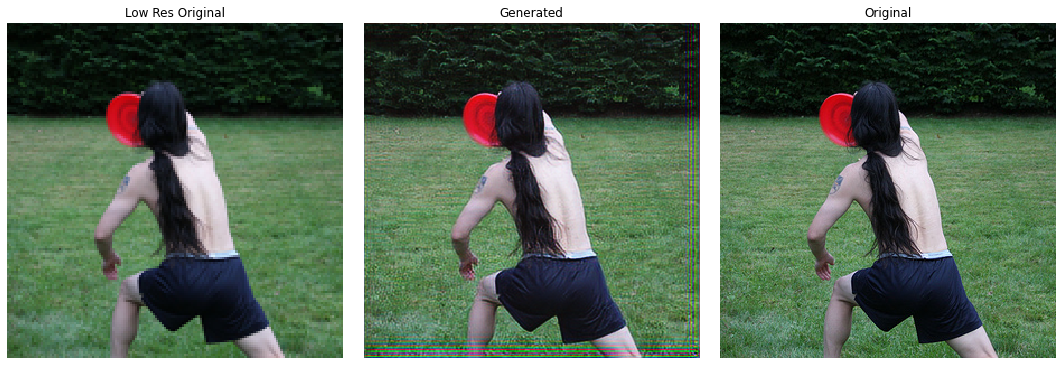


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------



100%|██████████| 474/474 [10:27<00:00,  1.32s/it]


discriminator_loss : 1.233770
gan_loss : [0.002579391, 0.0022593872, 0.32000384]
167


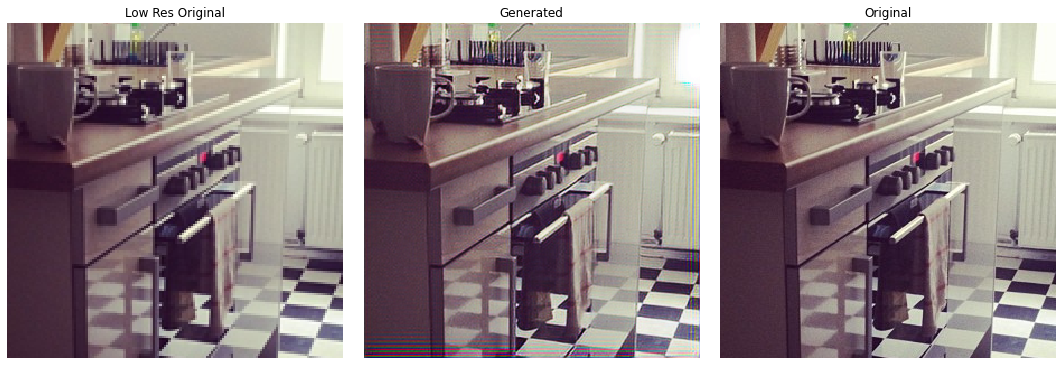


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------



100%|██████████| 474/474 [10:27<00:00,  1.32s/it]


discriminator_loss : 1.096738
gan_loss : [0.0025980757, 0.0022420534, 0.3560222]
167


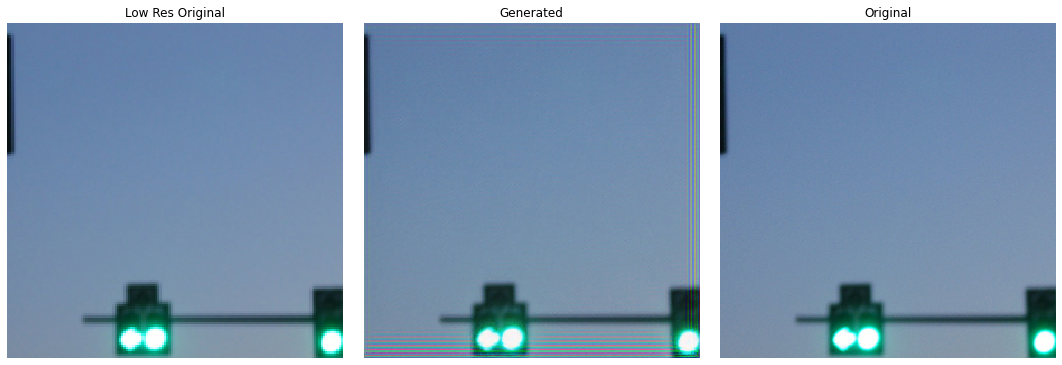


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------



100%|██████████| 474/474 [10:27<00:00,  1.32s/it]


discriminator_loss : 1.026118
gan_loss : [0.0025474105, 0.0021636598, 0.38375083]
167


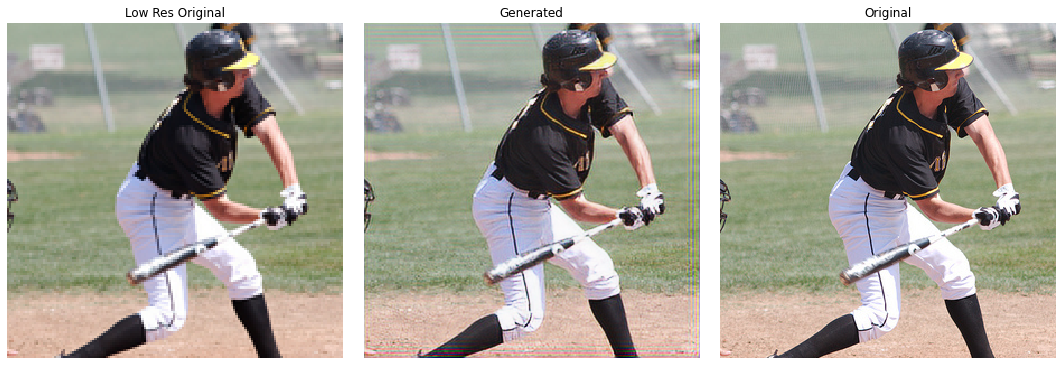


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------



100%|██████████| 474/474 [10:27<00:00,  1.32s/it]


discriminator_loss : 1.086032
gan_loss : [0.0027407664, 0.0023823774, 0.35838905]
167


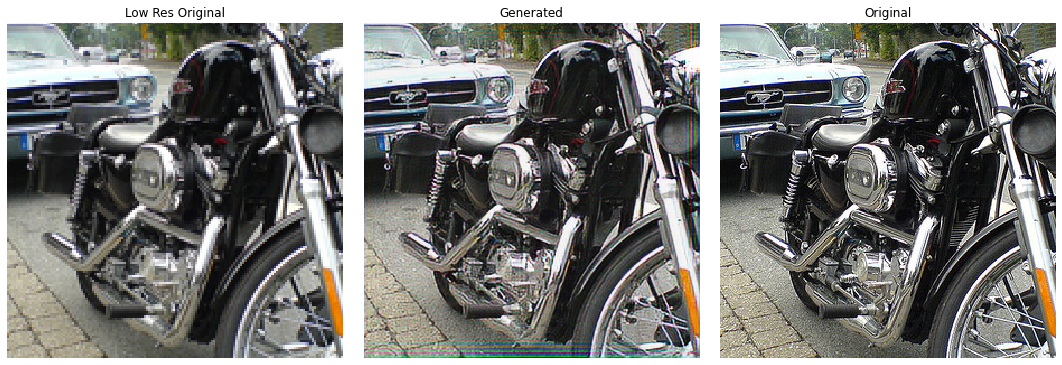


  0%|          | 0/474 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------



 76%|███████▌  | 358/474 [07:54<02:33,  1.32s/it]

In [0]:
gan.train(epochs = 10, batch_size = 10, input_imgs = img_data, output_dir = '/content/gdrive/My Drive/SR_Output_new', model_save_dir = '/content/gdrive/My Drive/SR_Model_new')

In [0]:
image = img_data[0][20]
image_og = denormalize(img_data[1][20])
gen_img = gan.gen.predict(np.expand_dims(image, axis = 0))
gen_img = denormalize(np.squeeze(gen_img, axis = 0))
for i in range(300):
  print("%f   %f \n"%(image_og[150][i][0], gen_img[150][i][0]))

In [0]:
(image_og[:,:,0]).shape

(300, 300)

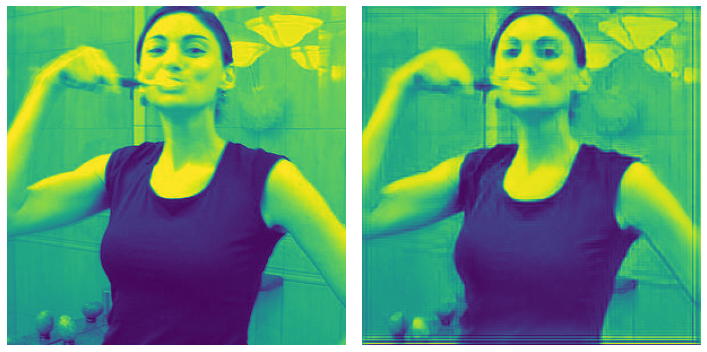

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image_og[:,:,0])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gen_img[:,:,0])
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
a = [1,2,10,4]
np.random.choice(a,4,False)

array([ 1,  4,  2, 10])